# Machine Learning: Wine Quality
---

## 1. Intro 📰

### 1.1 Data

We are going to explore a dataset containing physicochemical data from 🍷 **Red Wines** 🍷 of Potuguese's "Vinho Verde" type. The dataset indicates the **quality score** (0-10) given via sensorial to each wine.

### 1.2 Objective

Create two Machine Learning Models. One to predict the quality score and the other to classify a wine to "good" or "bad".

The focus will be on maximizing the metrics of the model in a balanced manner.

Premises:
- The Models to be used are from Linear and Logistic Regression.
- Good = quality score between 6 and 10.
- Bad = quality score between 1 and 5.

### 1.3 Metadata

From the [link](https://archive.ics.uci.edu/ml/datasets/Wine+Quality) where the dataset was downloaded:

- The dataset contains real data, collected on Oct 2009.
- There should be **NO** null values.
- The variables **ARE NOT** balanced.
- There is a possibility of **Outliers**.

It is also suggested that not all the 11 variables are relevante. They are:

1. fixed acidity 
2. volatile acidity 
3. citric acid 
4. residual sugar 
5. chlorides 
6. free sulfur dioxide 
7. total sulfur dioxide 
8. density 
9. pH 
10. sulphates 
11. alcohol

The 12˚ variable is the target: "quality". This class presents a score from 0-10 to a wine quality.

## 0. Preparing the Tool Box 🧰

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import normaltest, skew
from sklearn import metrics
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## 1. Collecting Data 📖

In [2]:
df_red = pd.read_csv(filepath_or_buffer='./data/winequality-red.csv', sep=';')

## 2. Exploratory Data Analysis 🧐

### 2.1 Exploring Structure

In [3]:
display(df_red.info(), df_red.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


None

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


There are 1599 records and no NaN values, every feature if of a continuous type and the target is of a discrete type.

Analyzing the first 5 lines of the dataset, we notice that the first and fourth lines are identical. It indicates that there may be duplicated data in the dataset.

In [4]:
# Analyzing the duplicates
print(f'{df_red.duplicated().sum()} duplicated records in '
      f'{len(df_red)} total records.',
      f'Resulting in {df_red.duplicated().sum()/len(df_red)*100:.1f}% of duplicated records.')

240 duplicated records in 1599 total records. Resulting in 15.0% of duplicated records.


15% of duplicated records is a significant amount. However, there is evidence to believe this data are real (and thus, the wine records are identical): there are no null values, there are few data in the dataset and the data collection has a method (documented in the link).

### 2.2 Preparing exploration

In [5]:
# Quantitative cotinuous variables
features = ['fixed acidity', 'volatile acidity', 'citric acid', 
            'residual sugar', 'chlorides', 'free sulfur dioxide', 
            'total sulfur dioxide', 'density', 'pH', 
            'sulphates', 'alcohol']

# Dependent target variable
target = 'quality'

# Setting a plot style
sns.set_style("ticks")

### 2.3 Exploring features (variables)

Given the sctructure of the Dataset, checking, in terms of **Location**, **Variability** and **Dispersion**:

Location and Variability:
- Stats:
    - Man
    - Median
    - Standard Deviation
    - Outliers presence (any value below or higher than 1.5*IQR)
- Visualization:
    - Boxplot
    
Distribution:
- Stats:
    - D'Agostino and Pearson Normality test result ($\alpha$ de 0.05)
    - *p-value* from the normality test.
    - Skewness
- Visualization:
    - Histogram

In [6]:
def explore_features(df, features, alpha=0.05):
    """ """
    for feature in features:
        fig, ax = plt.subplots(ncols=2, figsize=(16,3))
        fig.suptitle(f'Feature: {feature}', fontsize=14)

        # Boxplot
        sns.boxplot(data=df, x=feature, ax=ax[0], showmeans=True)
        ax[0].set_title('Location and Variability: Box-Plot')

        # Checking for outliers
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        outliers = (df[feature][(Q1-1.5*IQR >= df[feature]) 
                                | (df[feature] >= Q3+1.5*IQR)])
        if outliers.empty:
            has_outliers = 'No'
        else:
            has_outliers = 'Yes'

        # Presenting the stats
        ax[0].annotate(text=f'Mean: {df[feature].mean():.3f}\n'
                            f'Median: {df[feature].median():.3f}\n'
                            f'StdDev: {df[feature].std():.3f}\n'
                            f'Outliers: {has_outliers}',
                       xy=(1,1), xytext=(-12,-12),
                       xycoords='axes fraction', textcoords='offset points',
                       ha='right', va='top',
                       bbox=dict(facecolor='grey', alpha=0.2, pad=12))

        # Histogram
        sns.histplot(data=df, x=feature, ax=ax[1], kde=True)
        ax[1].set_title('Distribution: Histogram')
        ax[1].yaxis.label.set_visible(False)

        # Normality stats
        _, pvalue = normaltest(df[feature])
        skewness = skew(df[feature])

        # Normality test
        if pvalue < alpha:  # Null hypothesis: the distribution is normal
            normal = 'No'
        else:
            normal = 'Yes'

        # Presenting the stats
        ax[1].annotate(text=f'Normal: {normal}\n'
                            f'p-vaue: {pvalue:.3f}\n'
                            f'Skew: {skewness:.3f}',
                       xy=(1,1), xytext=(-12,-12),
                       xycoords='axes fraction', textcoords='offset points',
                       ha='right', va='top',
                       bbox=dict(facecolor='grey', alpha=0.2, pad=12))

        plt.show()
    

def explore_target(df, target):
    """ """
    fig, ax = plt.subplots(figsize=(16,4))
    
    # CountPlot
    sns.countplot(x='quality', data=df, ax=ax)
    ax.set_title(f'Distribution of {target}', fontsize=14)
    ax.set_xlabel(f'Values of {target}')
    ax.set_ylabel('Records')
    ax.bar_label(container=ax.containers[0], fontsize=11)
    
    # Calcuating the expected value 
    expected_value = (((df[target].value_counts().index 
                        * df[target].value_counts().values).values.sum())
                      / (df[target].value_counts().values.sum()))
    
    
    # Presenting the stats
    ax.annotate(text=f'Expected value: {expected_value:.2f}',
                   xy=(1,1), xytext=(-12,-12),
                   xycoords='axes fraction', textcoords='offset points',
                   ha='right', va='top',
                   bbox=dict(facecolor='grey', alpha=0.2, pad=12))

    plt.show()
    
    
def target_correlation(df, target):
    """ """
    fig, ax = plt.subplots(figsize=(16,2))
    
    # HeatMap
    data = df.corr().loc[[target],:].drop(target, axis=1)
    sns.heatmap(data=data, cmap='cividis', annot=True, ax=ax)
    ax.set_title(f'Correlation (Pearson) of the features x {target}', fontsize=14)
    ax.set_xlabel(f'Features')
    ax.tick_params(axis='x', labelrotation=45)
    
    plt.show()
    
    
def feature_correlation(df, target):
    """ """
    fig, ax = plt.subplots(figsize=(16,8))
    
    # HeatMap
    data = df.drop(target, axis=1).corr()
    sns.heatmap(data=data, cmap='cividis', annot=True, ax=ax)
    ax.set_title('Correlation (Pearson) between the features', fontsize=14)
    ax.tick_params(axis='x', labelrotation=45)

    plt.show()

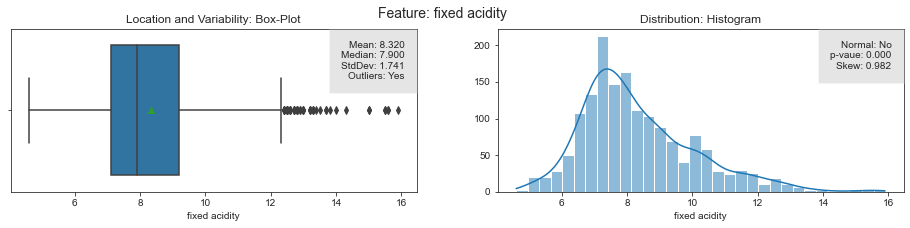

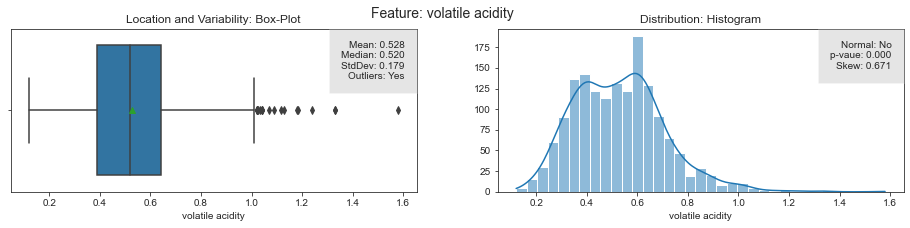

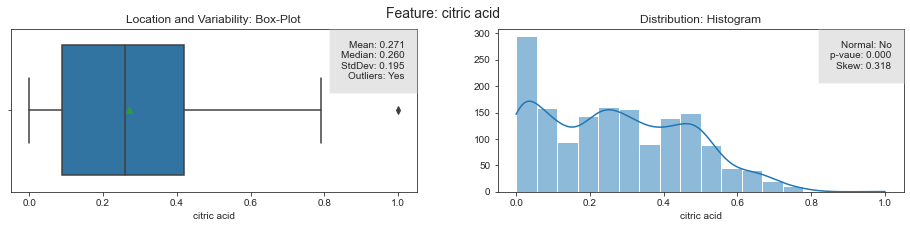

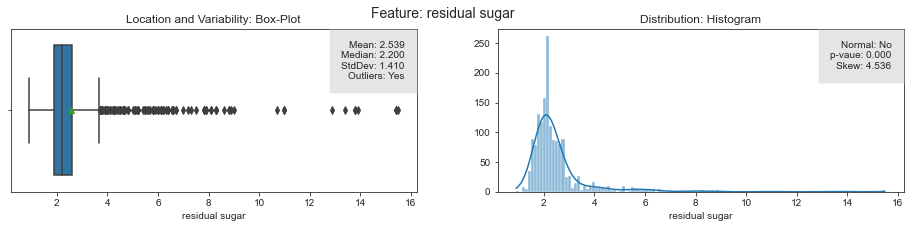

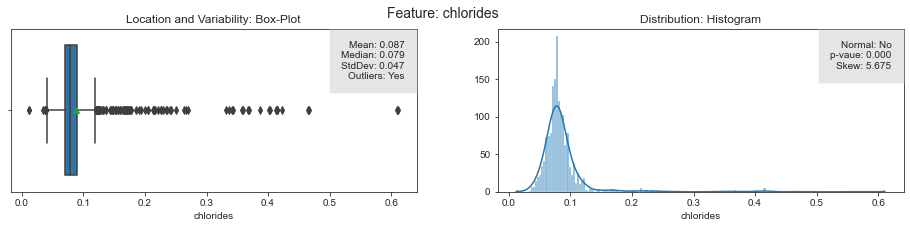

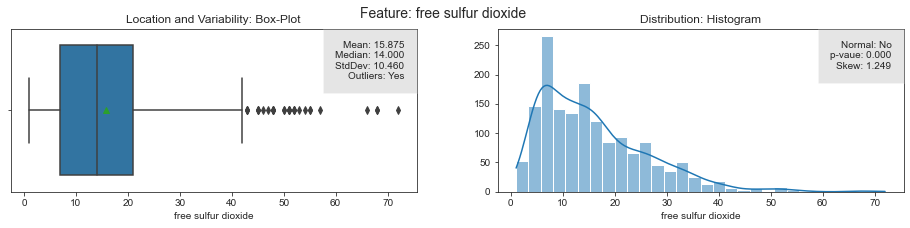

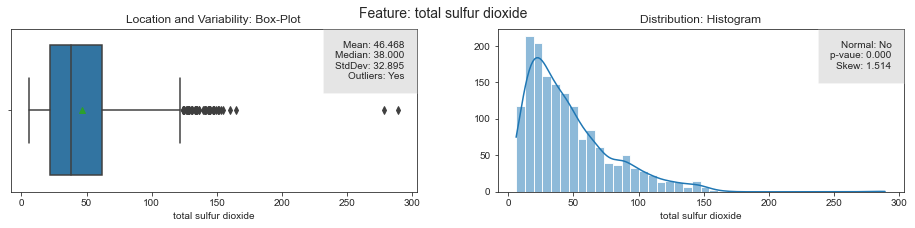

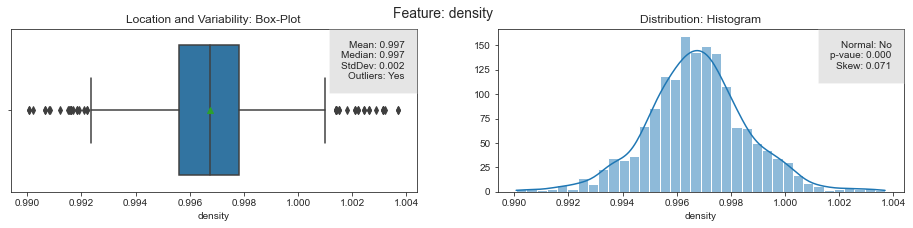

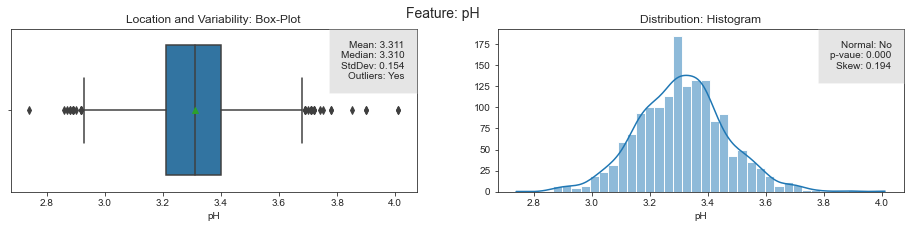

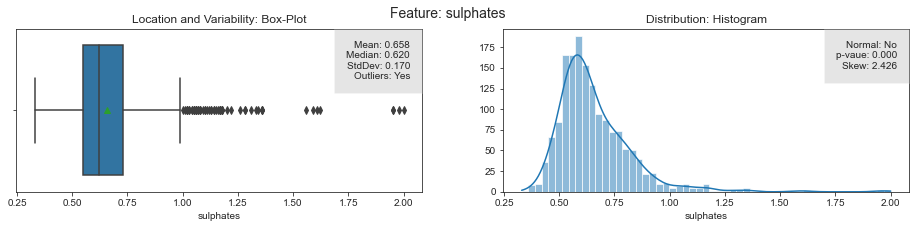

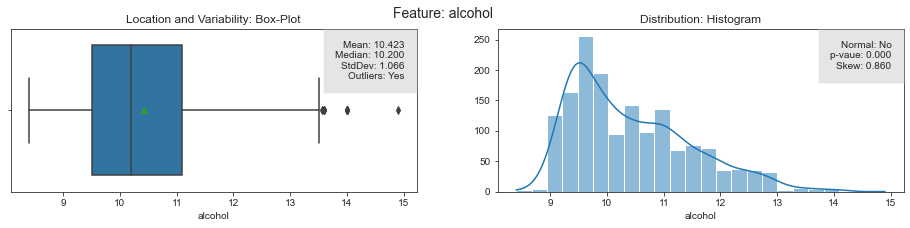

In [7]:
explore_features(df_red, features)

Notes:

- Every feature has Outliers (specially "residual sugar") and do not show a normal distribution.
- High Skewness in "fixed acidity", "citric acid", "chlorides", "total sulfur dioxide", and "sulphates" 

### 2.4 Exploring Target

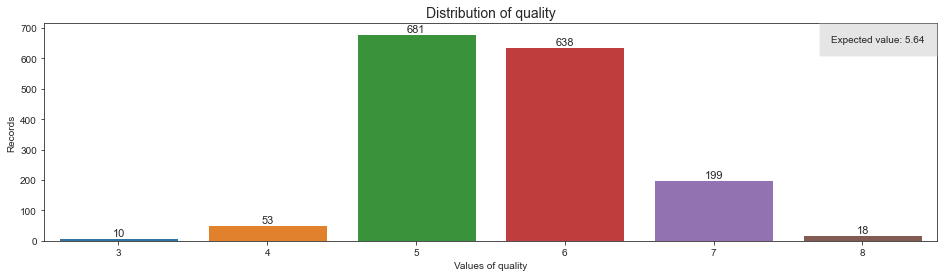

In [8]:
explore_target(df_red, target)

Notes:

- The data is not balanced and are very concentrated on "5" and "6".
- The low and high quality scores are basically outliers.

### 2.5 Exploring correlation

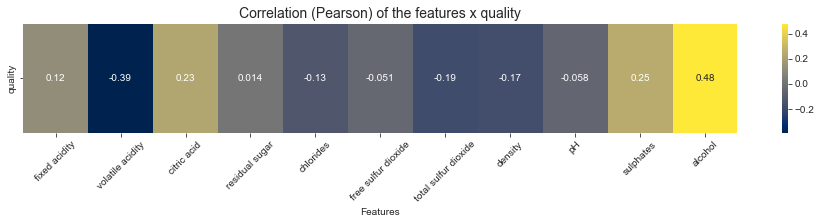

In [9]:
target_correlation(df_red, target)

Notes:

- "alcohol" is the feature with the most impact on "quality".
- "sulphates" and "citric acid" are the other more significant features.
- "volatile acidity" has the strongest negative correlation.
- The other features presents only small correlations.

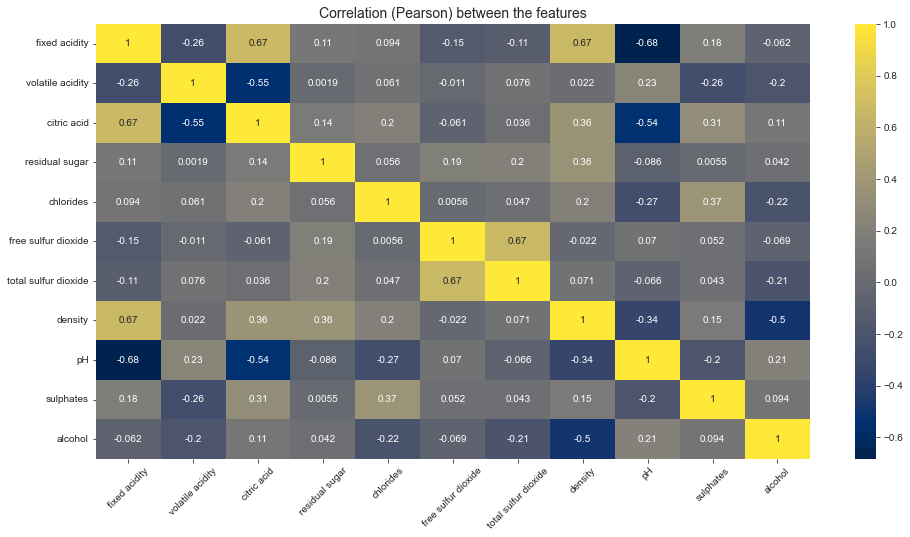

In [10]:
feature_correlation(df_red, target)

Notes:
- There is evidence of multicolinearity between the features: several coefficients are 0.5 or higher.

## 3. Setting Models (Linear and Logistic Regression) 🤖

In [11]:
def basic_linear_regression(df, features, target):
    """ """
    X = df[features]
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    R2 = metrics.r2_score(y_test, y_pred)
    MSE = metrics.mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(MSE)
    MAE = metrics.mean_absolute_error(y_test, y_pred)

    print('='*5+f'Linear Regression'+'='*3,
          'Metrics'+'-'*18,
          f'R2: {R2:.4f}',
          f'RMSE: {RMSE:.4f}',
          f'MAE: {MAE:.4f}',
          f'MSE: {MSE:.4f}\n',
          sep='\n')


def basic_logistic_regression(df, features, target):
    """ """
    X = df[features]
    y = np.vectorize(lambda y: 0 if y <= 5 else 1)(df[target])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LogisticRegression(max_iter=10000)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_score = model.decision_function(X_test)

    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision =  metrics.precision_score(y_test, y_pred)
    recall =  metrics.recall_score(y_test, y_pred)
    f1 =  metrics.f1_score(y_test, y_pred)
    roc_auc = metrics.roc_auc_score(y_test, y_score)

    precisions, recalls, thresholds_pr = metrics.precision_recall_curve(y_test, y_score)
    fpr, tpr, thresholds_roc = metrics.roc_curve(y_test, y_score)

    print('='*3+f'Logistic Regression'+'='*3,
          'Metrics'+'-'*18,
          f'Accuracy: {accuracy:.4f}',
          f'Precision: {precision:.4f}',
          f'Recall: {recall:.4f}',
          f'F1: {f1:.4f}',
          f'Area under ROC: {roc_auc:.4f}',
          sep='\n')
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,8))
    fig.suptitle('Visualization of Logistic Regression', fontsize=14)
    
    metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, colorbar=False, ax=ax[0,0])
    ax[0,0].set_title('Confusion Matrix')
    ax[0,1].plot(thresholds_pr, precisions[:-1], 'b--', label='Precision')
    ax[0,1].plot(thresholds_pr, recalls[:-1], 'g--', label='Recall')
    ax[0,1].set_title('Precision and Recall')
    metrics.PrecisionRecallDisplay.from_estimator(model, X_test, y_test, ax=ax[1,0])
    ax[1,0].set_title('PR Curve')
    metrics.RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax[1,1])
    ax[1,1].set_title('ROC Curve')

    fig.tight_layout()
    plt.show()

=====Linear Regression===
Metrics------------------
R2: 0.4032
RMSE: 0.6245
MAE: 0.5035
MSE: 0.3900

===Logistic Regression===
Metrics------------------
Accuracy: 0.7406
Precision: 0.7927
Recall: 0.7263
F1: 0.7580
Area under ROC: 0.8142


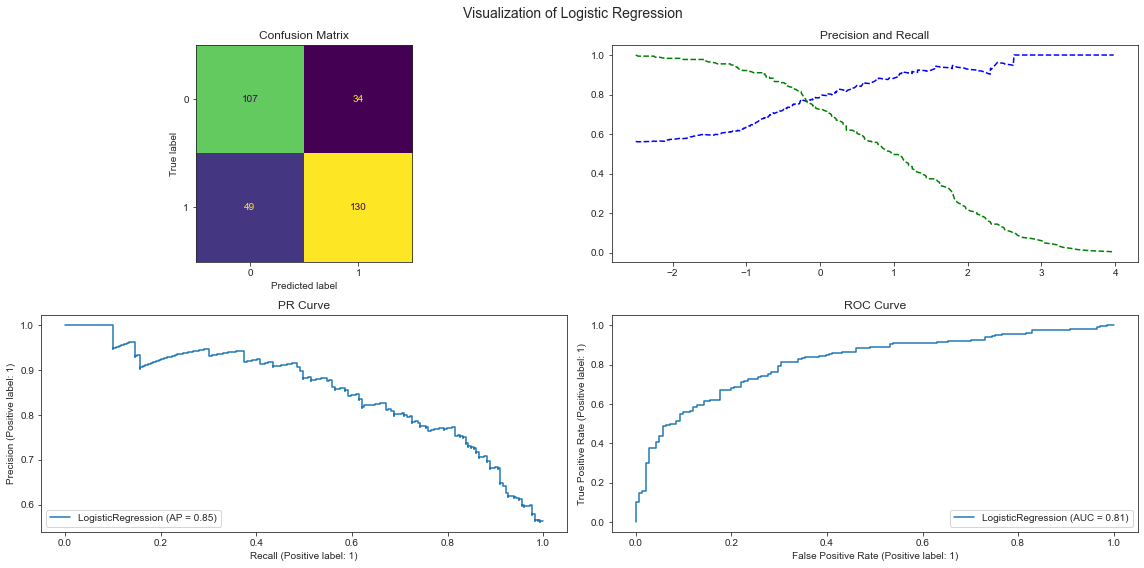

In [12]:
basic_linear_regression(df_red, features, target)
basic_logistic_regression(df_red, features, target)

## 4. Optimizing Models 🔧

### 4.1 EDA: Insights & Actions :

1. Handling the Outliers is an option. However, this might impact the unbalancing even further.
2. Normalize the features is an option.
3. In the features with high Skewness, the data might be transformed. This could even help with the outliers and lack of normality impact.
4. It is possible that not all features are significant to the model.
5. There is evidence of multicolinearity.
6. The target if of a discrete type. As the Linear Regression Model is created to predict continuous values, there will be an inherent error.
7. The high presence of duplicated data might impact the results of the models.

### 4.1 Parameters: Insights & Actions :

1. Stratify the data on "y" (target).
2. Use a *Standardization* *Regularization* method in the Models. **StandardScaler** will be applied to the Linear Regression and **MinMaxScaler** to the Logistic Regression.
3. Change the thresholds of Logistic Regression. As there is no business context, we will focus on optimizing the tmetrics in a balanced manner - no trade-offs of big impact. In this case, we will maximize the relation of $FPR+TPR-1$.
4. A *feature selection* will be used in the Logistic Regression,choosing a K number of featuresranked by ther R coefficient with the target.

In [13]:
def transform_to_log(df, features, target, threshold=1):
    """ """
    columns_to_transform = df.skew()[df.skew() > threshold].index.to_list()
    
    # Checking for infinite values on transformation
    for column in columns_to_transform:
        if np.isinf(df[column].apply(np.log)).any():
            columns_to_transform.remove(column) # Do not transform the column
    df[columns_to_transform] = df[columns_to_transform].apply(np.log)
    return df

In [14]:
df_red = transform_to_log(df_red, features, target)

In [15]:
def optimized_linear_regression(df, features, target):
    """ """
    X = df[features]
    y = df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    R2 = metrics.r2_score(y_test, y_pred)
    MSE = metrics.mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(MSE)
    MAE = metrics.mean_absolute_error(y_test, y_pred)

    print('='*5+f'Linear Regression'+'='*3,
          'Metrics'+'-'*18,
          f'R2: {R2:.4f}',
          f'RMSE: {RMSE:.4f}',
          f'MAE: {MAE:.4f}',
          f'MSE: {MSE:.4f}\n',
          sep='\n')


def optimized_logistic_regression(df, features, target):
    """ """
    X = df[features]
    y = np.vectorize(lambda y: 0 if y <= 5 else 1)(df[target])
    
    feature_selection = SelectKBest(score_func=f_regression, k=8)
    X = feature_selection.fit_transform(X, y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    
    y_score = model.predict_proba(X_test)[:,1]
    
    precisions, recalls, thresholds_pr = metrics.precision_recall_curve(y_test, y_score)
    fpr, tpr, thresholds_roc = metrics.roc_curve(y_test, y_score)
    optimized_thresold = thresholds_roc[np.argmin(np.abs(fpr+tpr-1))]
    
    y_pred = np.where(model.predict_proba(X_test)[:,1] > optimized_thresold, 1, 0)
    
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision =  metrics.precision_score(y_test, y_pred)
    recall =  metrics.recall_score(y_test, y_pred)
    f1 =  metrics.f1_score(y_test, y_pred)
    roc_auc = metrics.roc_auc_score(y_test, y_score)

    print('='*3+f'Logistic Regression'+'='*3,
          'Metrics'+'-'*18,
          f'Accuracy: {accuracy:.4f}',
          f'Precision: {precision:.4f}',
          f'Recall: {recall:.4f}',
          f'F1: {f1:.4f}',
          f'Area under ROC: {roc_auc:.4f}',
          sep='\n')
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,8))
    fig.suptitle('Visualization of Logistic Regression', fontsize=14)
    
    metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, colorbar=False, ax=ax[0,0])
    ax[0,0].set_title('Confusion Matrix')
    ax[0,1].plot(thresholds_pr, precisions[:-1], 'b--', label='Precision')
    ax[0,1].plot(thresholds_pr, recalls[:-1], 'g--', label='Recall')
    ax[0,1].set_title('Precision and Recall')
    metrics.PrecisionRecallDisplay.from_estimator(model, X_test, y_test, ax=ax[1,0])
    ax[1,0].set_title('PR Curve')
    metrics.RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax[1,1])
    ax[1,1].set_title('ROC Curve')

    fig.tight_layout()
    plt.show()

## 5. Setting Models Again (Linear and Logistic Regression) 🤖

=====Linear Regression===
Metrics------------------
R2: 0.4153
RMSE: 0.6182
MAE: 0.4970
MSE: 0.3821

===Logistic Regression===
Metrics------------------
Accuracy: 0.7469
Precision: 0.7917
Recall: 0.7430
F1: 0.7666
Area under ROC: 0.8202


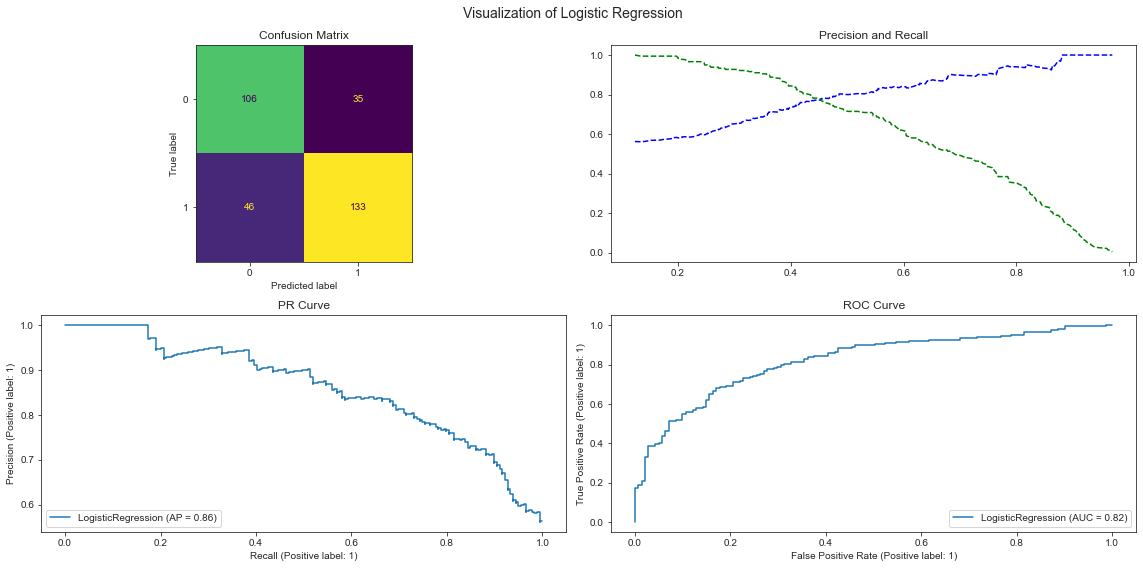

In [16]:
optimized_linear_regression(df_red, features, target)
optimized_logistic_regression(df_red, features, target)

## 6. Final Discussion 💬

Transforming the data with high skewness to the logarithmic scale, selecting features and choosing a differente threshold created marginal gains for the models.

### Linear Regression

Presented a low $Rˆ2$. In contrast, its erros metrics also had small values. Despiting testing some optimizations, there were no significant improvement.

We believe this model was specially impacted by the type and distribution of the target data. Also, no features presented a high coefficient with the target (as seen in the EDA).

### Logistic Regression
The Logistic Regression presented balanced metric - which is good, given our threshold choice.

Every metric of the model is above 74% and the area under ROC is superior to 82%. It is a trustworthy model.

### Improvements
- Despite the efforts to optimize the models, they did not show a lot of improvement. This leads us to believe that other models might better fit the data.
- As the data is unbalanced, using cross validation would probably be a better choice.
- Still about the unbalancing, we could have applied sampling techniques to the better address it.
- Normalize all features could potentially be a good idea.
- The log could be applied to all features or we could use different techniques to handle the skewness.
- Observe the kurtosis in the EDA.
- Observe the variability of the features (stratified by the target) could give us better insights about their correlation (or even find polynomial relations).